In [ ]:
!pip install contractions
!pip install Keras-Preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import contractions 

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset /Natural Language Processing/Sentiment Analysis/amazon_reviews_us_Jewelry_v1_00.tsv', error_bad_lines = False, sep='\t', header=0)
print(df.shape)

In [6]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,50423057,R135Q3VZ4DQN5N,B00JWXFDMG,657335467,Everbling Purple and Clear Briolette Drop Swar...,Jewelry,5,0.0,0.0,N,Y,Beauties!,so beautiful even tho clearly not high end ......,2015-08-31
1,US,11262325,R2N0QQ6R4T7YRY,B00W5T1H9W,26030170,925 Sterling Silver Finish 6ct Simulated Diamo...,Jewelry,5,0.0,0.0,N,N,Great product.,"Great product.. I got this set for my mother, ...",2015-08-31
2,US,27541121,R3N5JE5Y4T6W5M,B00M2L6KFY,697845240,"Sterling Silver Circle ""Friends Forever"" Infin...",Jewelry,5,0.0,0.0,N,Y,Exactly as pictured and my daughter's friend l...,Exactly as pictured and my daughter's friend l...,2015-08-31
3,US,5350721,R2I150CX5IVY9Q,B0006SW2WU,569859289,Surgical Stainless Steel Domed 9mm Fishbone Ri...,Jewelry,5,0.0,0.0,N,Y,Five Stars,Love it. Fits great. Super comfortable and nea...,2015-08-31
4,US,24484424,R1RM9ICOOA9MQ3,B009YPDW70,332947422,"Sterling Silver Family Pendant Necklace, 18""",Jewelry,5,0.0,0.0,N,Y,... a Mother's Day gift for my Mom and she lov...,Got this as a Mother's Day gift for my Mom and...,2015-08-31


# Exploratory Data Analysis 

In [7]:
df = df[['star_rating','review_body']]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1766992 entries, 0 to 1766991
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   star_rating  object
 1   review_body  object
dtypes: object(2)
memory usage: 27.0+ MB


Remove the Null, missing values and reset the index



In [9]:
df.isnull().sum()

star_rating      9
review_body    244
dtype: int64

In [8]:
df=df.dropna()
df = df.reset_index(drop=True)

In [9]:
#convert the star_rating column to int
df['star_rating']=df['star_rating'].astype(int) 

In [10]:
count_score = df['star_rating'].value_counts().sort_index()
count_score

1     155002
2     100797
3     159654
4     270424
5    1080871
Name: star_rating, dtype: int64

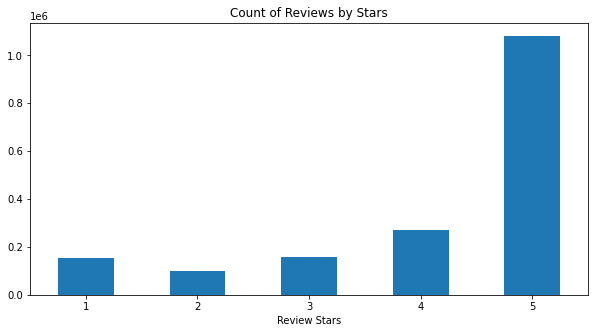

In [11]:
ax = count_score.plot(kind='bar', title='Count of Reviews by Stars', figsize=(10, 5))
ax.set_xlabel('Review Stars')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

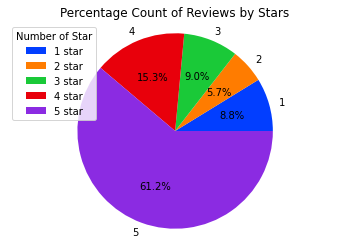

In [12]:
plt.pie(count_score, labels = ['1','2','3','4','5'], colors = sns.color_palette('bright')[0:], autopct='%1.1f%%', radius = 2)
plt.title('Percentage Count of Reviews by Stars')
plt.legend(loc = 'upper left', labels = ['1 star','2 star','3 star','4 star','5 star'], title = 'Number of Star')
plt.axis('equal')
plt.show()

Now we shuffle the reviews as to take random 50000 reviews for 5 labels star_rating and having the same size of sample

In [13]:
df = df.sample(frac=1).reset_index(drop=True) #shuffle
data=df[df['star_rating']==5][:10000]
data=data.append(df[df['star_rating']==4][:10000])
data=data.append(df[df['star_rating']==3][:10000])
data=data.append(df[df['star_rating']==2][:10000])
data=data.append(df[df['star_rating']==1][:10000])

In [16]:
#set the type 1 - Positive when 4,5 star; 0 - Neutral when 3 star, 2 - Negative for others
data['Type']=np.where(data['star_rating']>=4,'Positive',np.where(data['star_rating']==3,'Neutral','Negative'))

In [18]:
data=data.sample(frac=1).reset_index(drop=True)
data = data.reset_index(drop=True)
display(data['star_rating'].value_counts())
data

3    10000
4    10000
5    10000
1    10000
2    10000
Name: star_rating, dtype: int64

,star_rating,review_body,Type
0,3,"Don't get me wrong, they're cute but they're t...",Neutral
1,4,It's a flash drive bracelet. Theres nothing el...,Positive
2,3,"Ordered this for Christmas for my girlfriend, ...",Neutral
3,5,"Product is cheap price, but great quality! Arr...",Positive
4,3,"I love the bracelet, but I got 3 of them and o...",Neutral
...,...,...,...
49995,1,Took over a month to arrive and wasn't even th...,Negative
49996,5,Love it!,Positive
49997,1,Not real pearls and it is gold plated not soli...,Negative
49998,4,"A bit cheap looking, but gets the job done.",Positive


#Data Preprocessing

https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/

In [19]:
def Preprocess_text(text):
    # Remove the HTML tags and URLs
    text = text.apply(lambda x: BeautifulSoup(x).get_text())
    text = text.apply(lambda x: re.sub(r'http\S+', '', x))
    # Remove punctuations 
    text = text.apply(lambda x: " ".join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))
    # Remove extra spaces between words
    text = text.apply(lambda x: re.sub(' +',' ',x))
    # Remove the stopwords
    stop_w = stopwords.words('english')
    text = text.apply(lambda x: " ".join([x for x in x.split() if x not in stop_w]))
    # Perform contractions
    text = text.apply(lambda x: contractions.fix(x))
    # Convert all Text into lower case
    text = text.apply(lambda x: " ".join(x.lower() for x in str(x).split()))
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = text.apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))

    return text

In [20]:
data['preprocess'] = Preprocess_text(data['review_body'])

In [21]:
pd.set_option('display.max_colwidth', None)
data[['preprocess','review_body']].head()

,preprocess,review_body
0,do nt get wrong cute tiny wide top bottom whoever wrote spec product included measurement weight,"Don't get me wrong, they're cute but they're tiny. 3/8\\"" wide by 1/2\\"" top to bottom. Whoever wrote the specs for this product should have included the measurements, not just the weight."
1,it flash drive bracelet there is nothing else going it pretty awesome concept since known losebreak many flash drive it work perfectly flash drive tends tad bulky wrist slip occasionally still totally worth money once get hang putting one hand nt problem,"It's a flash drive bracelet. Theres nothing else going on here. It's a pretty awesome concept since i've been known to lose/break many a flash drive. It works perfectly as a flash drive, tends to be a tad bulky on the wrist and can slip off occasionally, but still totally worth the money. Once you get the hang of putting it on with one hand you shouldn't have any problem"
2,ordered christmas girlfriend promise ring nice pre engagement kind of thing know like basically wanted say hey honey let u together forever sound good now ring i real problem ring i wish little bigger i know cheap everything sound goodlooks good picture ring really small hopefully girlspousewhatever love perfect the shinyness size nt much look i still think great buy given chance one hundred dollar little time i would gotten something else fine,"Ordered this for Christmas for my girlfriend, we're 18 so a promise ring is a nice \\""pre engagement\\"" kinda thing you know? Like basically just wanted to say \\""Hey honey, lets be together forever sound good?\\"" NOW about the ring. I have no real problems with the ring, all I wish was it was a little bigger..I know its cheap and everything and sounds good/looks good in the picture but this ring is really small. Hopefully if your girl/spouse/whatever loves you for you then it'll be perfect. The shinyness and size aren't too much to look at but I still think it was a great buy all and all. Given the chance of one hundred more dollars and a little more time I would have gotten something else but this will do just fine. (:"
3,product cheap price great quality arrived timely exactly said it hard see design along edge though,"Product is cheap price, but great quality! Arrived timely and is exactly what it said. It is hard to see the design along the edges though."
4,i love bracelet i got made right way the others longer worded slate upside nt possible fix but still cute,"I love the bracelet, but I got 3 of them and only 1 was made the right way. The others had the longer worded slate upside down, and it isn't possible to fix it. But they are still cute"


# Visualize Word_cloud

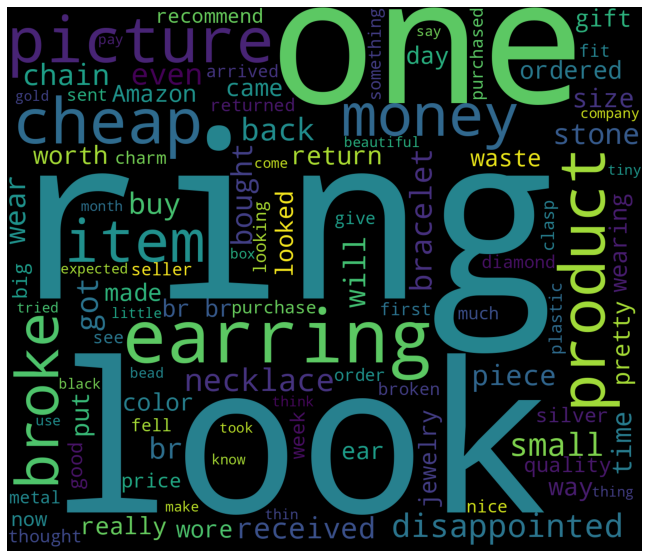

In [85]:
from wordcloud import WordCloud 
# Negative reviews
w_cloud = ' '.join(word for word in data['preprocess'][data['star_rating']==1].astype(str))
plt.subplots(figsize=(15,10))
wordcloud = WordCloud(
                          background_color='black',
                          max_words=100,
                          width=1400,
                          height=1200
                         ).generate(w_cloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

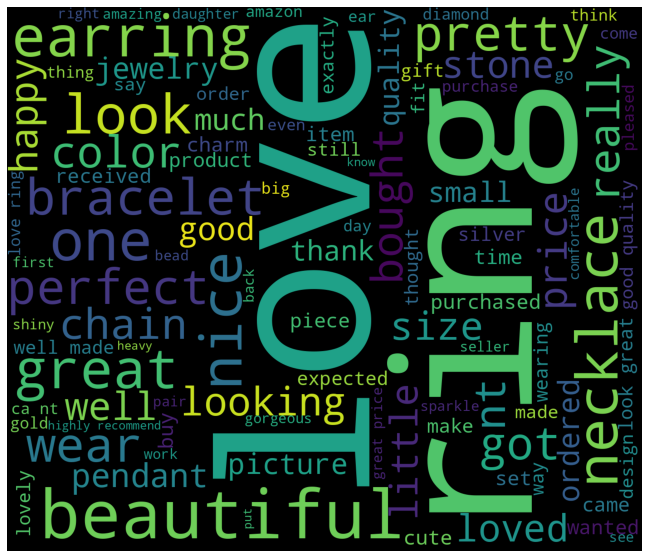

In [84]:
# Positive reviews
w_cloud = ' '.join(word for word in data['preprocess'][data['star_rating']==5].astype(str))
plt.subplots(figsize=(15,10))
wordcloud = WordCloud(
                          background_color='black',
                          max_words=100,
                          width=1400,
                          height=1200
                         ).generate(w_cloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Implement LSTM model

https://medium.com/mlearning-ai/sentiment-analysis-using-lstm-21767a130857

https://www.analyticsvidhya.com/blog/2021/06/natural-language-processing-sentiment-analysis-using-lstm/

In [22]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation
from tensorflow.keras.layers import Bidirectional, SpatialDropout1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping

## Tokenization and Padding

I wanna save the text for concat with result before embedding it into a vector and don't have to worry about it shuffled because I set random_state = 42 for stable shuffling

In [30]:
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(data['preprocess'],data['star_rating'], test_size = 0.3, random_state = 42, shuffle = True)
print(X_train_text.shape,y_train_text.shape)
print(X_test_text.shape,y_test_text.shape)

(35000,) (35000,)
(15000,) (15000,)


In [23]:
data.preprocess.map(lambda x: len(x)).max()

4971

In [33]:
Vocab_size = 5000 # following the max size of vocab above
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=Vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(data['preprocess'].values)

In [34]:
train_text = tokenizer.texts_to_sequences(data['preprocess'].values)
train_text = pad_sequences(train_text, maxlen=MAX_SEQUENCE_LENGTH, padding = 'post')
print('Shape of data tensor:', train_text.shape)
print(train_text)

Shape of data tensor: (50000, 250)
[[ 130    4   24 ...    0    0    0]
 [   5 2129 2669 ...    0    0    0]
 [  71  170  362 ...    0    0    0]
 ...
 [  32  118  151 ...    0    0    0]
 [  97   84   37 ...    0    0    0]
 [   2   36    1 ...    0    0    0]]


In [35]:
# for i in range(max_seq):
#     indexword = i % lencmt
#     if (seq_len - i < lencmt):
#         break
#     if(words[indexword] in words_label):
#         matrix[i] = model[words[indexword]]

# This code can use instead of zero padding efficiently but I ain't sure =)) Cause they have discussed at: 
# https://viblo.asia/p/phan-tich-phan-hoi-khach-hang-hieu-qua-voi-machine-learningvietnamese-sentiment-analysis-Eb85opXOK2G

## Split Data

In [49]:
X_train, X_test, y_train, y_test = train_test_split(train_text,data['star_rating'], test_size = 0.3, random_state = 42, shuffle = True)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(35000, 250) (35000,)
(15000, 250) (15000,)


Check test and train data label distribution is balanced ?

In [50]:
print(y_train.value_counts().values)
print(y_test.value_counts().values)
# yeah its balanced cause I have already chosen balanced sample =))

[7033 7011 7003 6981 6972]
[3028 3019 2997 2989 2967]


## Embedding Label

In [51]:
y_train.head()
#don't pay attention to index =))

38094    1
40624    5
49425    3
35734    5
41708    2
Name: star_rating, dtype: int64

I wanna embedd label with each rate compatible with there position in list

For instance, 2 star --> [0, 1, 0, 0, 0] ; 5 star --> [0, 0, 0, 0, 1] 

but because sample is shuffled so a dictionary have keys according to the first unique values and values (dict) start from 0 --> 4 =)) so keep track on category

In [52]:
category = data['star_rating'].unique()
category_to_id = {cate: idx for idx, cate in enumerate(category)}
id_to_category = {idx: cate for idx, cate in enumerate(category)}
print(category_to_id)
print(id_to_category)

{3: 0, 4: 1, 5: 2, 1: 3, 2: 4}
{0: 3, 1: 4, 2: 5, 3: 1, 4: 2}


In [53]:
y_ = y_train.map(category_to_id).values
y_train = np.zeros((len(y_), y_.max()+1))
y_train[np.arange(len(y_)), y_] = 1

y_ = y_test.map(category_to_id).values
y_test = np.zeros((len(y_), y_.max()+1))
y_test[np.arange(len(y_)), y_] = 1

print(y_train.shape, y_test.shape)

(35000, 5) (15000, 5)


In [54]:
print(y_train)

[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


## LSTM model

In [66]:
model = Sequential()
model.add(Embedding(Vocab_size, EMBEDDING_DIM, input_length = train_text.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(128, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True)))
model.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 250, 100)          500000    
                                                                 
 spatial_dropout1d_8 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_13 (Bidirecti  (None, 250, 256)         234496    
 onal)                                                           
                                                                 
 bidirectional_14 (Bidirecti  (None, 64)               73984     
 onal)                                                           
                                                                 
 dense_19 (Dense)            (None, 64)                4160      
                                                      

In [ ]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=5,  min_delta=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=1e6)
checkpoint = ModelCheckpoint('best_full.h5', monitor='val_loss',
                             verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

In [67]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64,validation_split=0.1, verbose = 1,
                    callbacks=[es, reduce_lr, checkpoint])

Epoch 1/20
493/493 [==============================] - 1865s 4s/step - loss: 1.3113 - accuracy: 0.3954 - val_loss: 1.1664 - val_accuracy: 0.4797
Epoch 2/20
493/493 [==============================] - 1782s 4s/step - loss: 1.1243 - accuracy: 0.5010 - val_loss: 1.1149 - val_accuracy: 0.5046
Epoch 3/20
493/493 [==============================] - 1785s 4s/step - loss: 1.0646 - accuracy: 0.5343 - val_loss: 1.1046 - val_accuracy: 0.5100
Epoch 4/20
493/493 [==============================] - 1792s 4s/step - loss: 1.0215 - accuracy: 0.5533 - val_loss: 1.1141 - val_accuracy: 0.5054
Epoch 5/20
493/493 [==============================] - 1794s 4s/step - loss: 0.9950 - accuracy: 0.5630 - val_loss: 1.1187 - val_accuracy: 0.5123
Epoch 6/20
493/493 [==============================] - 1791s 4s/step - loss: 0.9680 - accuracy: 0.5837 - val_loss: 1.1409 - val_accuracy: 0.5009


# Evaluation

In [36]:
model.evaluate(X_test,y_test)

469/469 [==============================] - 199s 424ms/step - loss: 1.1585 - accuracy: 0.5101


[1.1585150957107544, 0.5100666880607605]

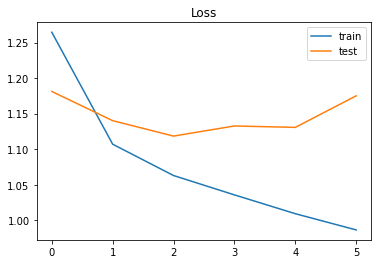

In [34]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

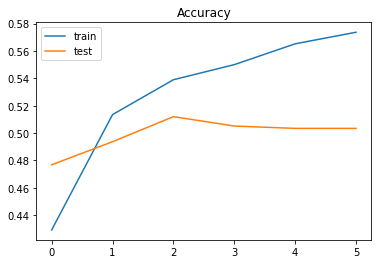

In [35]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [68]:
predicted = model.predict(X_test)
predicted

469/469 [==============================] - 146s 310ms/step


array([[0.59684247, 0.08527315, 0.00553915, 0.04550423, 0.26684102],
       [0.18258546, 0.51210254, 0.24343294, 0.01216358, 0.04971545],
       [0.57142997, 0.20747712, 0.01950513, 0.02816781, 0.17341994],
       ...,
       [0.23743246, 0.05911271, 0.02606874, 0.3071592 , 0.3702269 ],
       [0.45519617, 0.18915975, 0.02965658, 0.06061804, 0.2653695 ],
       [0.09402329, 0.6802023 , 0.21464291, 0.00086171, 0.01026975]],
      dtype=float32)

In [76]:
compare_df = pd.DataFrame(data = list(zip(y_test, predicted)), columns=['Actual','Predicted'])
compare_df

,Actual,Predicted
0,"[1.0, 0.0, 0.0, 0.0, 0.0]","[0.59684247, 0.085273154, 0.005539148, 0.045504227, 0.26684102]"
1,"[0.0, 0.0, 0.0, 1.0, 0.0]","[0.18258546, 0.51210254, 0.24343294, 0.012163583, 0.049715452]"
2,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.57142997, 0.20747712, 0.019505128, 0.02816781, 0.17341994]"
3,"[1.0, 0.0, 0.0, 0.0, 0.0]","[0.4432852, 0.052768648, 0.0035854192, 0.07237895, 0.42798164]"
4,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.3066021, 0.039484333, 0.0048243576, 0.14249365, 0.5065956]"
...,...,...
14995,"[1.0, 0.0, 0.0, 0.0, 0.0]","[0.4304926, 0.08223413, 0.009348709, 0.09006995, 0.38785452]"
14996,"[0.0, 1.0, 0.0, 0.0, 0.0]","[0.025350984, 0.17721175, 0.78412306, 0.004470317, 0.008843787]"
14997,"[0.0, 0.0, 0.0, 1.0, 0.0]","[0.23743246, 0.059112713, 0.02606874, 0.3071592, 0.3702269]"
14998,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.45519617, 0.18915975, 0.029656583, 0.060618035, 0.2653695]"


In [69]:
X_test_temp_df = pd.DataFrame(X_test_text)
X_test_temp_df = X_test_temp_df.reset_index(drop=True)

# set a new index starting with 0
X_test_temp_df = X_test_temp_df.set_index(pd.Index(range(len(X_test_temp_df))))

In [77]:
compare_df['Actual'] = compare_df['Actual'].apply(lambda x: np.argmax(x) + 1)
compare_df['Predicted'] = compare_df['Predicted'].apply(lambda x: np.argmax(x) + 1)

In [78]:
compare_df = pd.concat([compare_df,X_test_temp_df], axis = 1)

In [79]:
compare_df.head()

,Actual,Predicted,preprocess
0,1,1,it okay nt like quality ring came
1,4,2,bought earring gift year old grandaughter love horseback riding they tiny could barely see definately worth price
2,5,1,much larger i thought would however good quality product may pas along friend like larger size
3,1,1,it definitely pretty picture but main disappointment part looked little dentedwarped like roundness uneven i considered returning went ahead gave gift it pretty nt look closely
4,5,5,the ring looked great lot like one trying replace however slat well finished rough rubbed husband finger raw we issue first ring slat i read review similar assumed man wearing sissy man like husband turn right apology the edge slat are sharp we buy something else replace he could stand wear day


Text(0.5, 51.0, 'Predicted')

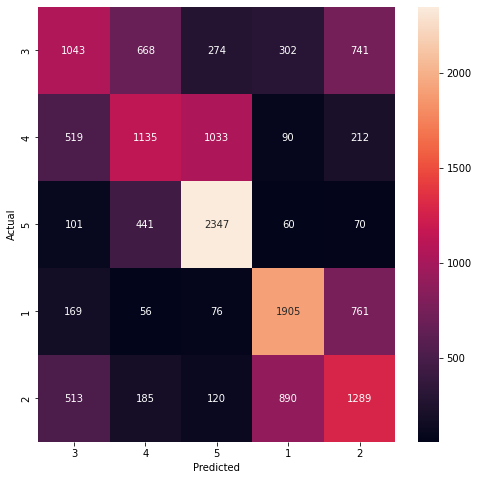

In [80]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8, 8))
conf_mat = confusion_matrix(compare_df['Actual'], compare_df['Predicted'])
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=id_to_category.values(), yticklabels=id_to_category.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')

#The end
